<a href="https://colab.research.google.com/github/Dagobert42/langID-NLP/blob/master/langID_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Dataset Preparation
This subsection contains methods to produce uniformly distributed chunks of our data set. From these we can then obtain n-grams of different sizes. The Wikipedia Language Identification database contains txt-files of x_train and x_test for example sentences and accordingly ordered labels in y_train, y_test.

In [ ]:
import numpy as np
import pandas as pd
import string, re, time, math
import nltk
from nltk import ngrams
import collections
from collections import defaultdict
from collections import Counter
from IPython.display import clear_output

In [ ]:
!npx degit Dagobert42/langID-NLP/WiLI-2018_data -f

npx: installed 1 in 1.563s
> destination directory is not empty. Using --force, continuing
> cloned Dagobert42/langID-NLP#master


In [ ]:
# read data
# written for the WiLI-2018 data set: https://zenodo.org/record/841984
X_train = open('x_train.txt', encoding="utf8").read().split('\n')
Y_train = open('y_train.txt', encoding="utf8").read().split('\n')
X_test = open('x_test.txt', encoding="utf8").read().split('\n')
Y_test = open('y_test.txt', encoding="utf8").read().split('\n')
labels = pd.read_csv('labels.csv', delimiter = ';')

In [ ]:
def preprocess(X,Y):
    '''
    preprocessing the data

    Output example:
    x_train = [ex1, ex2, ex3, ...]
    y_train = [lang_of_ex1, ...]

    '''
    # convert language labels to language Name => 'en' -> 'English'
    lab_dict = { labels.loc[i]['Label'] : labels.loc[i]['English'] for i in range(0, len(labels)) }
    y_train = [ lab_dict[item] if item != 'nan' else 'Min Nan Chinese' for item in Y ]

    # remove unnecessary characters from data
    extras = '!"$%&/{}[]()=?\\`´*+~#-_.:,;<>|1234567890°-\''
    rx = '[' + re.escape(''.join(extras)) + ']'
    x_train = [] 
    to_remove = []
    i = 0
    for example in X:
        processed = re.sub(' +', ' ', re.sub(rx, '', example))
        # some examples only contain spaces after preprocessing
        # this is a check for those examples
        if len("".join(processed.split())):
            x_train.append(processed)
        else:
            y_train.pop(i)
        i+=1

    return x_train, y_train

In [ ]:
def data_by_lang(X, Y):
    '''
    sort data by language
    
    Output example:
    lang_corpora = { 'Lang1' : [ex1, ex2, ...], 'Lang2' : [ex1, ex2, , ...], ...}
    lang_idx = { 'Lang1' : [23, 41, ...], 'Lang2' : [1, 19, ...], ...}

    '''
    lang_corpora = defaultdict(list)
    lang_idx = defaultdict(list)
    for i in range(len(X)):
        lang_corpora[Y[i]].append(X[i])
        lang_idx[Y[i]].append(i)

    return lang_corpora, lang_idx

In [ ]:
def get_data_chunk(X, Y, n_samples, lang_keys=[]):
    
    '''
    extract uniformly distributed list of examples from our data set
    takes an optional argument to constrain the list of languages

    Output example:
    x_train [ lang1_ex1, lang1_ex2, ..., lang2_ex, lang2_ex, ...]
    y_train [ lang1, lang1, ...lang2, lang2, ...]

    '''
    _, lang_idx = data_by_lang(X, Y)
    x_train = []
    y_train = []
    
    langs = set()
    if lang_keys: 
        langs = set(lang_keys)
    else:
        langs = set(Y)

    for lang in langs:
        indices = lang_idx[lang]
        if(len(indices) < n_samples):
          n_samples = len(indices)
        for index in range(n_samples):
            x_train.append(X[indices[index]])
            y_train.append(Y[indices[index]])

    return x_train, y_train

In [ ]:
def make_n_grams(X, Y, n, lang_keys=[], stepsize=1):
    '''
    creating n-grams for each data entry
    optional arguments:
        lang_keys - constrains the languages to use
        stepsize  - specifies the amount of characters
                    to jump until the next n-gram

    Output example:
    x_to_grams = [[ngram_in_ex1], [ngram_in_ex2], ...]

    '''
    assert stepsize >= 1
    x_to_grams = []

    langs = set()
    if lang_keys: 
        langs = set(lang_keys)
    else:
        langs = set(Y)

    for i in range(len(X)):
        if Y[i] in langs:
            sent = X[i]
            x_to_grams.append([sent[j:j+n] for j in range(0, len(sent) - n+1, stepsize)])

    return x_to_grams

In [ ]:
def sort_by_tf(X, Y):
    '''
    calculating term frequency of n-grams per language
    counting and sorting n-grams for each language
    
    Output example:
    sorted_tf_per_lang = { lang1 : {n_gram1 : count}, ...}

    '''
    tf_per_lang = defaultdict(list)
    langs = set(Y)
    data, _ = data_by_lang(X, Y)
    for lang,gram_list in data.items():
      data[lang] = [ gram for grams in gram_list for gram in grams] # convert list of lists to a single list
    for lang in langs:
        tf_per_lang[lang] = dict(
            zip(list(Counter(data[lang]).keys()),
                 list(Counter(data[lang]).values())))

    # sort by term frequency
    sorted_tf_per_lang = defaultdict(list)
    for lang in langs:
        sorted_tf_per_lang[lang] = { word : value for word, value in sorted(tf_per_lang[lang].items(), key=lambda item:item[1], reverse=True) }
    
    return sorted_tf_per_lang

### 2. Understanding Data
In the following we review some examples to get an understanding of our data.
Particularly interesting are languages with a degree of similarity, as these are a greater challenge for classification. Here we print examples of n-grams from languages that use the Latin alphabet.
Starting with trigrams, and taking the 20 most common from each language, we see that many languages have a few in common. This is above all the case with languages which are closely related. Here we have examples from the Latin family, the Germanic family, and single examples from their families (Estonian, Turkish). At the trigram level, we even see plenty of intersection between languages which aren't related at all (French, Estonian), or only distantly (German, Romanian).

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
def make_barplots(n_gram_size, lang_key, commoncollect, base_counts, compare_counts, otherlangs, concise=True):
    width = 0.35  # the width of the bars
    if len(otherlangs) > 6 and concise==False:
        nrows = 3
        ncols = 3
        figsize=(22, 10)
    elif len(otherlangs) > 4 and concise==False:
        nrows = 2
        ncols = 3
        figsize=(22, 10)
    elif len(otherlangs) > 1 and concise==False:
        nrows = 1
        ncols = len(otherlangs)
        if len(otherlangs) == 4:
            figsize=(26, 5)
        else:
            figsize=(18, 4)
    elif len(otherlangs) == 1 or concise==True:
        try:
            fig, ax = plt.subplots(figsize=(7, 4))
            fig.suptitle('Frequency of %s-grams in %s compared to %s:' % (n_gram_size, lang_key, otherlangs[0]),  fontsize=16)
            x = np.arange(len(commoncollect[0]))  # the label locations   
            rects1 = ax.bar(x - width/2, base_counts[0], width, color = 'r', label=lang_key)
            rects2 = ax.bar(x + width/2, compare_counts[0], width, color = 'g', label=otherlangs[0])
            ax.set_xticks(x)
            ax.set_xticklabels(commoncollect[0], fontsize=14)
            ax.legend(fontsize=12)
            plt.show()
        except IndexError:
            print('there was an IndexError')
            return
        return

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharey = 'row', figsize=figsize)
    fig.suptitle('Frequency of %s-grams in %s compared to other languages:' % (n_gram_size, lang_key),  fontsize=20)
    for ax, common_ngrams, counts_langkey, counts_otherlang, otherlang in zip(axes.flatten(), commoncollect, base_counts, compare_counts, otherlangs):
        x = np.arange(len(common_ngrams)) 
        rects1 = ax.bar(x - width/2, counts_langkey, width, color = 'r', label=lang_key)
        rects2 = ax.bar(x + width/2, counts_otherlang, width, color = 'g', label=otherlang)
        ax.set_xticks(x)
        ax.set_xticklabels(common_ngrams, fontsize=14)
        ax.legend(fontsize=12)
        
    return

As we increase the size of our n-grams, the number of examples declines dramatically, as does the intersection between the commonest n-grams in various languages. Even at 4-grams, we see that the Germanic and Latin families are delineated from each other. Higher than that, and only the Latin languages still have some n-grams in common with each other, at least among the top 20 most frequent. This suggests that longer n-grams can more quickly lead to accurate identification of a language.

In [ ]:
x_train, y_train = preprocess(X_train[:-1],Y_train[:-1])

latin_languages = ['German', 'English', 'French', 'Spanish', 'Italian', 'Portuguese', 
                    'Estonian', 'Turkish', 'Romanian', 'Swedish', 'Latin', 'Dutch']
                    
# produces charts of counts of common n-grams in different languages, and tables suggesting similar languages based on these

for n_gram_size in range(4,7):
    m_samples = 20

    ng_related = {}
    
    x_train_grams = make_n_grams(x_train, y_train, n_gram_size, stepsize = n_gram_size)
    sorted_tf_per_lang = sort_by_tf(x_train_grams, y_train)

    for lang_key in latin_languages:

        ng_related[lang_key] = []
        latin_languages.remove(lang_key)
        latin_langs = latin_languages
        top_m = list(sorted_tf_per_lang[lang_key].keys())[:m_samples]

        commoncollect, base_counts, compare_counts, otherlangs = [], [], [], []

        for otherlang in latin_langs:
            top_m_x = list(sorted_tf_per_lang[otherlang].keys())[:m_samples]
            common_ngrams = list(set(top_m).intersection(top_m_x))
            
            if len(common_ngrams) > 2:
                
                ng_related[lang_key].append(otherlang)
                
                # get counts of the entries in common_ngrams for each language.
                # These are stored as the values corresponding to the n-gram keys in the dictionary
                counts_langkey = []
                counts_otherlang = []
                for i in common_ngrams:
                    counts_langkey.append(sorted_tf_per_lang[lang_key][i])
                    counts_otherlang.append(sorted_tf_per_lang[otherlang][i])

                common_ngrams = [k.replace(' ', '_') for k in common_ngrams]
                
                #print(lang_key, "and", otherlang, "have the following frequent", n_gram_size,"-grams in common:",common_ngrams)
                #print('\n ')

                commoncollect.append(common_ngrams)
                base_counts.append(counts_langkey)
                compare_counts.append(counts_otherlang)
                otherlangs.append(otherlang)

        if commoncollect:
        # this sorting operation is to position the largest n-gram intersections at the top of the lists.
            commoncollect, base_counts, compare_counts, otherlangs = zip(*sorted(zip(commoncollect, base_counts, compare_counts, otherlangs), key=lambda x: len(x[0]), reverse=True))
 
            # set parameter "concise" to False if you want an extensive set of bar charts in the output
            make_barplots(n_gram_size, lang_key, commoncollect, 
                          base_counts, compare_counts, otherlangs, concise=True)
        
        latin_languages = ['German', 'English', 'French', 'Spanish', 'Italian', 'Portuguese', 
                           'Estonian', 'Turkish', 'Romanian', 'Swedish', 'Latin', 'Dutch']                    
    
    print('similar languages based on ', n_gram_size, '- grams:')
    for key, val in ng_related.items():
        print(key, ':', val)
    
    print('\n ')

# since the output produced by this cell is quite large
# please clear it before the commit so as not to inflate the notebook
time.sleep(120)
clear_output()

Due to time and memory constraints we have found it to be inefficient to train and evaluate the performance of our models on the entire dataset. To solve this problem we define subsets of languages to train on to avoid huge encodings. We define two subsets of distinct languages and two subsets of similar languages.

In [ ]:
# languages with different scripts or alphabets
diff_alph_langs = ['Arabic', 'Russian', 'Cherokee', 'Central Khmer', 'Standard Chinese', 'Japanese', 
                   'Modern Greek', 'Hebrew', 'English']

# languages from different families (https://glottolog.org/glottolog/family)
diff_fam_langs = ['Afrikaans', 'Albanian', 'Cherokee', 'Javanese', 'Hungarian', 'Turkish', 
                   'Japanese', 'Arabic', 'English']

# Latin-alphabet languages with similar 4-grams (see Section 2 "Understanding Data")
latin_4_grams = ['French', 'English', 'Italian', 'Portuguese', 'Estonian',
                 'Turkish', 'Romanian', 'Swedish', 'Latin', 'Dutch']

# groups of similar languages from DSL benchmark (https://arxiv.org/abs/1610.00031)
dsl_groups_ABCG = ['Bosnian', 'Croatian', 'Serbian', # A
                   'Indonesian', 'Malay', # B
                   'Czech', 'Slovak', # C
                   'Bulgarian', 'Macedonian'] # G

### Naive Bayes Classifier
To obtain a baseline for the language identification task we employ a Gaussian Naive Bayes classifier and observe how it performs on the language identification task.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB

In [ ]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
def get_top_n_features(X_grams, Y, n_features):
    '''
    extracts lists of top n frequent n-grams from data

    X : [[ngram_in_ex1], [ngram_in_ex2], ...]
    Y : ['lang1', 'lang1', ..., 'lang2', ...]
    n_features : number of ngram to pick from each language

    Output example:
    features : ['and', 'he ', 'öä ', ...]

    '''
    sorted_freq_per_lang = sort_by_tf(X_grams, Y)
    features = []
    for lang, grams_dict in sorted_freq_per_lang.items():
        i = 0
        for gram, count in grams_dict.items():
            if i <= n_features:
                features.append(gram)
            else:
                break
            i += 1
      
    return list(set(features))

In [ ]:
def create_feature_matrix(X, features):
    '''
    convert data to feature matrix

    X : [[ngram_in_ex1], [ngram_in_ex2], ...]
    features : ['and', 'he ', 'öä ', ...] top ngrams from corpus

    Output example:
    mat : array([[4,1,2,1,...],[1,1,1,2,3,1,...],...])

    '''
    mat = np.zeros((len(X),len(features)))
    i = 0
    for gram_list in X:
        gram_count = []
        for gram in features:          
            if gram in gram_list:
                gram_count.append(gram_list.count(gram)+1)
            else:
                gram_count.append(1)
        mat[i] = gram_count
        i+=1

    return mat

In [ ]:
n_instances = 500 # instance per language, must be less than 500
n_gram_size = 4
n_features = 20 # features per language
n_lang = 11
start = time.time()
print("Starting preprocessing at {} ..".format(time_since(start)))

x_train, y_train = preprocess(X_train[:-1], Y_train[:-1])

print("Preprocessing done at {}.".format(time_since(start)))

avail_lang = list(set(y_train))
rand_idx = random.sample(range(0,235),n_lang)
lang_group = np.array(avail_lang)[rand_idx] # Selecting n_lang random language for training

# reduce languages to get smaller data subset
x_train, y_train = get_data_chunk(x_train, y_train, n_instances,dsl_groups_ABCG)

print('Making', str(n_gram_size) + '-grams at {} ..'.format(time_since(start)))
x_train_grams = make_n_grams(x_train, y_train, n_gram_size)

print('Extracting', n_features, 'features at {} ...'.format(time_since(start)))
# create features for dataset
features = get_top_n_features(x_train_grams, y_train, n_features)

print('Creating feature matrix at {}  ....'.format(time_since(start)))
# convert dataset into feature matrix
feature_matrix = create_feature_matrix(x_train_grams, features)
print('Data preparation completed after {}'.format(time_since(start)))

Starting preprocessing at 0m 0s ..
Preprocessing Done at 0m 3s.
Making ngrams at 0m 3s ..
Extracting features at 0m 3s ...
Creating feature matrix at 0m 4s  ....
Data Preperation completed after 0m 8s


In [ ]:
# Gaussian Naive Bayes model training
encoder = LabelEncoder()
X = feature_matrix
Y = encoder.fit_transform(y_train)
model = GaussianNB()
model.fit(X,Y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
# model testing
start = time.time()
print('Test Data preperation starting ...')
x,y = preprocess(X_test[:-1], Y_test[:-1])

n_instances = 500

x,y = get_data_chunk(x,y,n_instances, dsl_groups_ABCG)

print('Making', str(n_gram_size) + '-grams at {} ..'.format(time_since(start)))
x_test_grams = make_n_grams(x, y, n_gram_size)

print('Extracting', n_features, 'features at {} ...'.format(time_since(start)))
x = create_feature_matrix(x_test_grams, features)
print('Test data preparation completed after {}'.format(time_since(start)))

y = encoder.fit_transform(y)
y_pred = model.predict(x)

Test Data preperation starting ...
Making ngrams at 0m 3s ..
Creating feature matrix at 0m 3s  ....
Test Data Preperation completed after 0m 7s


Accuracy is 73.81%
f1-score is 0.6990231395467179


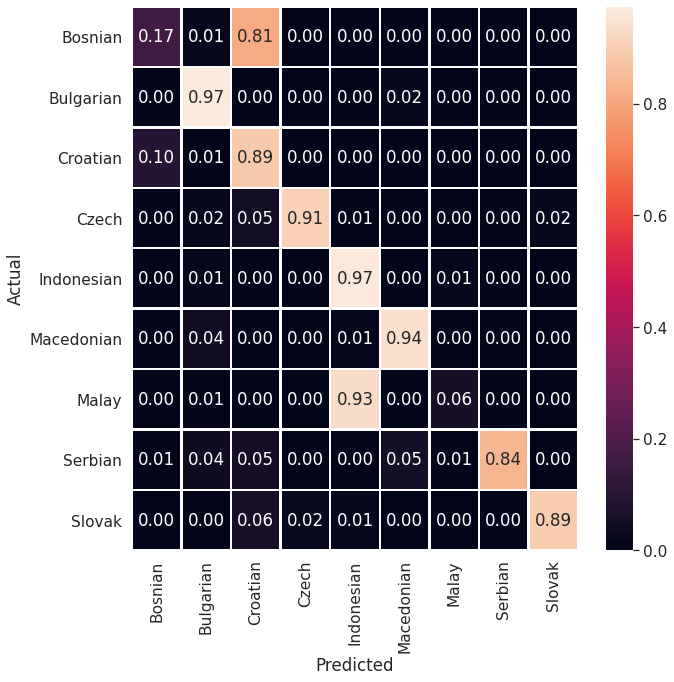

In [ ]:
# model evaluation
acc = round(accuracy_score(y_pred=y_pred, y_true=y), 4) * 100
print(f"Accuracy is {acc}%")

f1score = f1_score(y,y_pred,average='weighted')
print(f"f1-score is {f1score}")

y1 = encoder.inverse_transform(y)
y2 = encoder.inverse_transform(y_pred)
conf_matrix = confusion_matrix(y_pred=y2, y_true=y1)
df_cm = pd.DataFrame(conf_matrix/conf_matrix.astype(np.float).sum(axis=1), columns=np.unique(y1), index = np.unique(y1))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,10))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, fmt=".2f", linewidths=1.5)

### 4. Recurrent Neural Network

In this section we introduce a Recurrent Neural Network (RNN) model for language identification task. The model is of a many-to-one type, meaning that we provide a sequence of data units (n-grams in our case) to multiple RNN cells which produces an output at the last cell.

In [ ]:
import torch
from torch.autograd import Variable 
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# helper to print progress bars of this length
bar_len = 20

**CHANGE TO GPU MODE**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

There are three layers in this model. First is an Embedding Layer which converts input data into embeddings, second is a Gated Recurrent Unit and finally a Linear Layer to provide the probability distribution over different languages.

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hid_size, output_size, layers, embedding):

        super(RNN, self).__init__()
        self.hidden_dim = hid_size
        self.layers = layers
        self.embedding_size = embedding 
        self.dropout = nn.Dropout(0.4)
        self.input_size = input_size
        self.output_size = output_size
        self.embeddings = nn.Embedding(self.input_size,self.embedding_size)
        self.rnn = nn.GRU(input_size=self.embedding_size,hidden_size=self.hidden_dim,num_layers = self.layers)
        self.linear = nn.Linear(self.hidden_dim,self.output_size)

    
    def forward(self, x):
        '''
        x : B x S where B is batch size and S is sequence size
        Sequence size is length of one ngram vector encoding

        '''
        batch_size = x.size(0) 
        x = x.t() 
        embedded = self.embeddings(x) # S x B x I , here I is input_size/vocab size
        hidden = self._init_hidden(batch_size)
        output,hidden = self.rnn(embedded,hidden)
        output = self.dropout(output) 
        fc_output = self.linear(output[-1]) # B x L , L is number of classes/languages
        return fc_output

    def _init_hidden(self,batch_size):
        hidden_state = torch.zeros(self.layers,batch_size, self.hidden_dim, device=device)
        return hidden_state

First we extract a number of samples from each language of the given corpus. It is also possible to constrain the data to a subset of languages. Each instance in this reduced dataset is converted into n-grams of a fixed length. Our vocabulary is created by choosing a number of top n-grams by term-frequency and then mapping them to an index which we can use to create encodings.

In [ ]:
def prepare_data(X, Y, n_samples, n_gram_size, n_features, lang_keys=[]):
    '''
    Data is prepared in 3 steps:
    1. N-grams are created from given dataset i.e each example is converted into a list of n-grams.
    2. These n-grams are used to create vocabulary.
    3. Finally dataset is converted into encodings to feed into RNN.

    '''
    # reduce languages to get smaller data subset
    print('Preparing', n_samples, 'samples per language')
    x_train, y_train = get_data_chunk(X, Y, n_samples, lang_keys)

    print('Making', str(n_gram_size) + '-grams at {} ..'.format(time_since(start)))
    x_train_grams = make_n_grams(x_train, y_train, n_gram_size, lang_keys)

    # create features for dataset
    print('Extracting', n_features, 'features at {} ...'.format(time_since(start)))
    features = get_top_n_features(x_train_grams, y_train, n_features)
    vocabulary = {word: i for i, word in enumerate(features)}

    inp, target, _ = create_encodings(x_train_grams, y_train, vocabulary)
    return vocabulary, inp, target, 

N-grams in each example are converted into encodings using our indeces. For each sample, if an n-gram is present in our vocabulary, its index is used as an encoding. This results in a vector of integers for each example. However, these vectors can be of different lengths, which might create problems when we train a model with a batch of input data. So in order to make vectors of equal length we pad it with zeros at the end.

In [ ]:
def create_encodings(X_grams, Y, vocabulary):
    '''
    encodes lists of n-grams as vectors containing indices from our vocabulary
    
    X_grams : [[ngram_in_ex1],[ngram_in_ex2],....]
    Y : ['lang1','lang1',...,'lang2',....]
    vocabulary : {' of':1,'apf':2,....}
    
    Output example:
    inp : tensor([[12, 342, ..., 0],[56, 2311, ...], ...])
    target : tensor([41, 127, 234, 16, ...])

    '''
    x_grams = []
    y_grams = []
    gram_len = []
    iter = len(X_grams)/10
    print('Creating Encoding for X')
    for j in range(len(X_grams)):
        gramlist = X_grams[j] # list of ngrams in example j
        gramlist = list(dict.fromkeys(sorted(gramlist,key=gramlist.count,reverse=True)))
        grams = [vocabulary[w] for w in gramlist if w in list(vocabulary.keys()) ] 
        
        if (len(grams) >= 1): # resulting grams list must not be empty
            x_grams.append(grams) # Add encodings to x_grams
            gram_len.append(len(grams)) # Add corresponding data
            y_grams.append(Y[j])

        if (j % iter == 0):
            print('\r{}% data prepared at time {}'.format((j/len(X_grams))*100, time_since(start)), end=' ')
    
    print('\r{}% data prepared at time {}'.format(100, time_since(start)), end=' ')
    gram_len = torch.LongTensor(gram_len)
    inp = padding(x_grams,gram_len)

    print('\nCreating Encoding for Y')
    label = list(set(y_grams))
    labels_to_idx = { lang:i  for i,lang in enumerate(label)}
    y_label = torch.zeros(len(y_grams),device=device).long()
    for i in range(len(y_label)):
        y_label[i] = labels_to_idx[y_grams[i]]
    target = Variable(torch.cuda.LongTensor(y_label))

    return inp, target, labels_to_idx

In [ ]:
def padding(vector_inps, lengths):
    '''
    takes variable lengths vectors and convert them into equal length by padding zeros
    Input : "vector_inps" list of vectors containing indices of ngrams
            "lengths " length of each vector
    Output : tensor containing vectors of equal length after padding
             This length is equal to maximum number(M) in list of "lengths"

    '''
    inp_tensor = torch.zeros((len(vector_inps),lengths.max()), device= device).long()
    for idx, (seq, seq_len) in enumerate(zip(vector_inps,lengths)):
        inp_tensor[idx, :seq_len] = torch.LongTensor(seq)

    return inp_tensor

In [ ]:
def start_training(X, Y, input_size, hidden_size=64, n_layers=1, embedding_size=64, lr=0.001, batch=64, n_epochs=1000):
    '''
    train model over multiple epochs
    Output : trained model,
             list of losses for every epoch,
             list of f1_scores for every epoch
    
    '''
    output_size = len(set(Y.cpu().numpy())) # number of languages
    model = RNN(input_size, hidden_size, output_size, n_layers, embedding_size).to(device)
    decoder_optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    print_every = n_epochs/10
    all_losses = []
    f1_scores = []

    print('Training:')
    for epoch in range(1, n_epochs+1):
        loss, score = train(model, criterion, decoder_optimizer, X, target, batch)
        all_losses.append(loss)
        f1_scores.append(score)
        if(epoch % print_every == 0):
            i = math.ceil(epoch/n_epochs * bar_len)
            print('\r', '#' * i, ' ' * (bar_len-i), epoch/n_epochs * 100, '%',
                  '[{} epoch: {} loss: {:.4f}]'.format(time_since(start), epoch, loss), end=' ')
            
    return model, all_losses, f1_scores

In [ ]:
def train(decoder, criterion, decoder_optimizer, inp, target, batch=100):
    '''
    train RNN model
    decoder : Model
    inp : tensor([[12, 342, ..., 0],[56, 2311, ...], ...])
    target : tensor([41, 127, 234, 16, ...])
    
    '''
    decoder.zero_grad()
    loss = 0
    score = 0
    for i in range(1,int(len(inp)/batch)):
        # input to model should be in form B x S where B is batch size and S is sequence size
        output = decoder(inp[(i-1) * batch: (i) * batch].view(batch, -1))
        loss += criterion(output, target[(i-1)*batch:(i)*batch])
        out = output.argmax(dim=1)
        score += f1_score(target[(i-1)*batch:(i)*batch].cpu().numpy(),out.cpu().numpy(),average='weighted')
    loss.backward()
    decoder_optimizer.step()
    score = score/int(len(inp)/batch)

    return loss.item(), score

In [ ]:
def predict(model, test_x, test_y, labels_map):
    '''
    provides predictions the given model
    decoder : Model
    test_x  : tensor([[12,342,...,0],[56,2311,....],....]) Example encodings
    true : tensor([41,127,234,16,....]) Label Encodings

    '''
    out = model(test_x) # out : B x L, where B is batch size and L is number of Labels/Classes
    out = out.argmax(dim=1)
    correct = out.eq(test_y.data.view_as(out)).cpu().sum()
    
    accuracy = (correct/len(test_x))*100
    print("Accuracy is {}%".format(accuracy))

    f1score = f1_score(test_y.cpu().numpy(),out.cpu().numpy(),average='weighted')
    print(f"f1-score is {f1score}")
    
    # Convert label encoding to labels
    out = [ list(labels_map.keys())[list(labels_map.values()).index(i)] for i in out ] 
    test_y = [ list(labels_map.keys())[list(labels_map.values()).index(i)] for i in test_y ]

    conf_matrix = confusion_matrix(y_pred=out, y_true=test_y)
    df_cm = pd.DataFrame(conf_matrix/conf_matrix.astype(np.float).sum(axis=1), columns = np.unique(test_y), index = np.unique(test_y))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,10))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm,annot=True,fmt=".2f",linewidths=1.5)
    plt.show()

    return accuracy

In [ ]:
def test_model(model, x_test, y_test, n_gram_size, vocab): 
    start = time.time()
 
    print('Making', str(n_gram_size) + '-grams at {} ..'.format(time_since(start)))
    x_test_grams = make_n_grams(x_test, y_test, n_gram_size)
 
    print('Preparing encoding for Test Data at {}'.format(time_since(start))) 
    inp_t, true, labels_map = create_encodings(x_test_grams, y_test, vocab) 
    print('Encoding completed at {}'.format(time_since(start))) 
 
    return predict(model, inp_t, true, labels_map)

### 5. Testing and Evaluation

For testing we need to prepare our data again so that it has the required format. After the data is prepared we feed it to the model which returns a probability distribution for each example.

**Hyper Parameter Tuning**

In [ ]:
gram_log = defaultdict(dict)

n_gram_list = [3,5,8]
n_instance = 200
n_feature = 10
parameters = {'n_epochs':[1000,3000,5000],'hidden_size':[64,128,256],'n_layers':[1,2,3],'lr':[0.001,0.005,0.01,0.05,0.1]}
X_Train, Y_Train = preprocess(X_train[:-1], Y_train[:-1])
X_Test, Y_Test = preprocess(X_test[:-1], Y_test[:-1])

for n_gram in n_gram_list:
  param_log = defaultdict(lambda: defaultdict(list))
  start = time.time()
  vocab, inp, target = prepare_data(X_Train, Y_Train, n_instance, n_gram, n_feature, dsl_groups_ABCG)
  input_size = len(vocab)
  x_test, y_test = get_data_chunk(X_Test, Y_Test, n_instance, dsl_groups_ABCG)
  for key,value in parameters.items():
      for val in value:
          args = {key:val}
          model, losses, scores = start_training(inp, target, input_size, **args)
          param_log[key]['losses'].append(losses)
          param_log[key]['f1_score'].append(scores)
          acc = test_model(model, x_test, y_test, n_gram, vocab)
          param_log[key]['accuracy'].append(acc)
  gram_log[n_gram] = param_log


# since the output produced by this cell is quite large
# please clear it before the commit so as not to inflate the notebook
time.sleep(120)
clear_output()

In [ ]:
def plot_results(param, y_label):
  fig, axs = plt.subplots(3, 3,figsize = (24,20))
  for i in range(0,3):
    
    gram = n_gram_list[i]
    data = gram_log[gram]
    for j in range(0,3):
      if j == 0 :
        col = 'lr'
        axs[i, j].set_title('LR')
      elif j == 1:
        col = 'hidden_size'
        axs[i, j].set_title('Hidden Size')
      elif j == 2:
        col = 'n_layers'
        axs[i, j].set_title('Layer/s')
      lst = data[col][param]
      for val in lst:
        axs[i,j].plot(val)
        axs[i,j].legend(parameters[col])
    
  for ax in axs.flat:
      ax.set(xlabel='epochs', ylabel=y_label)

  # Hide x labels and tick labels for top plots and y ticks for right plots.
  for ax in axs.flat:
      ax.label_outer()


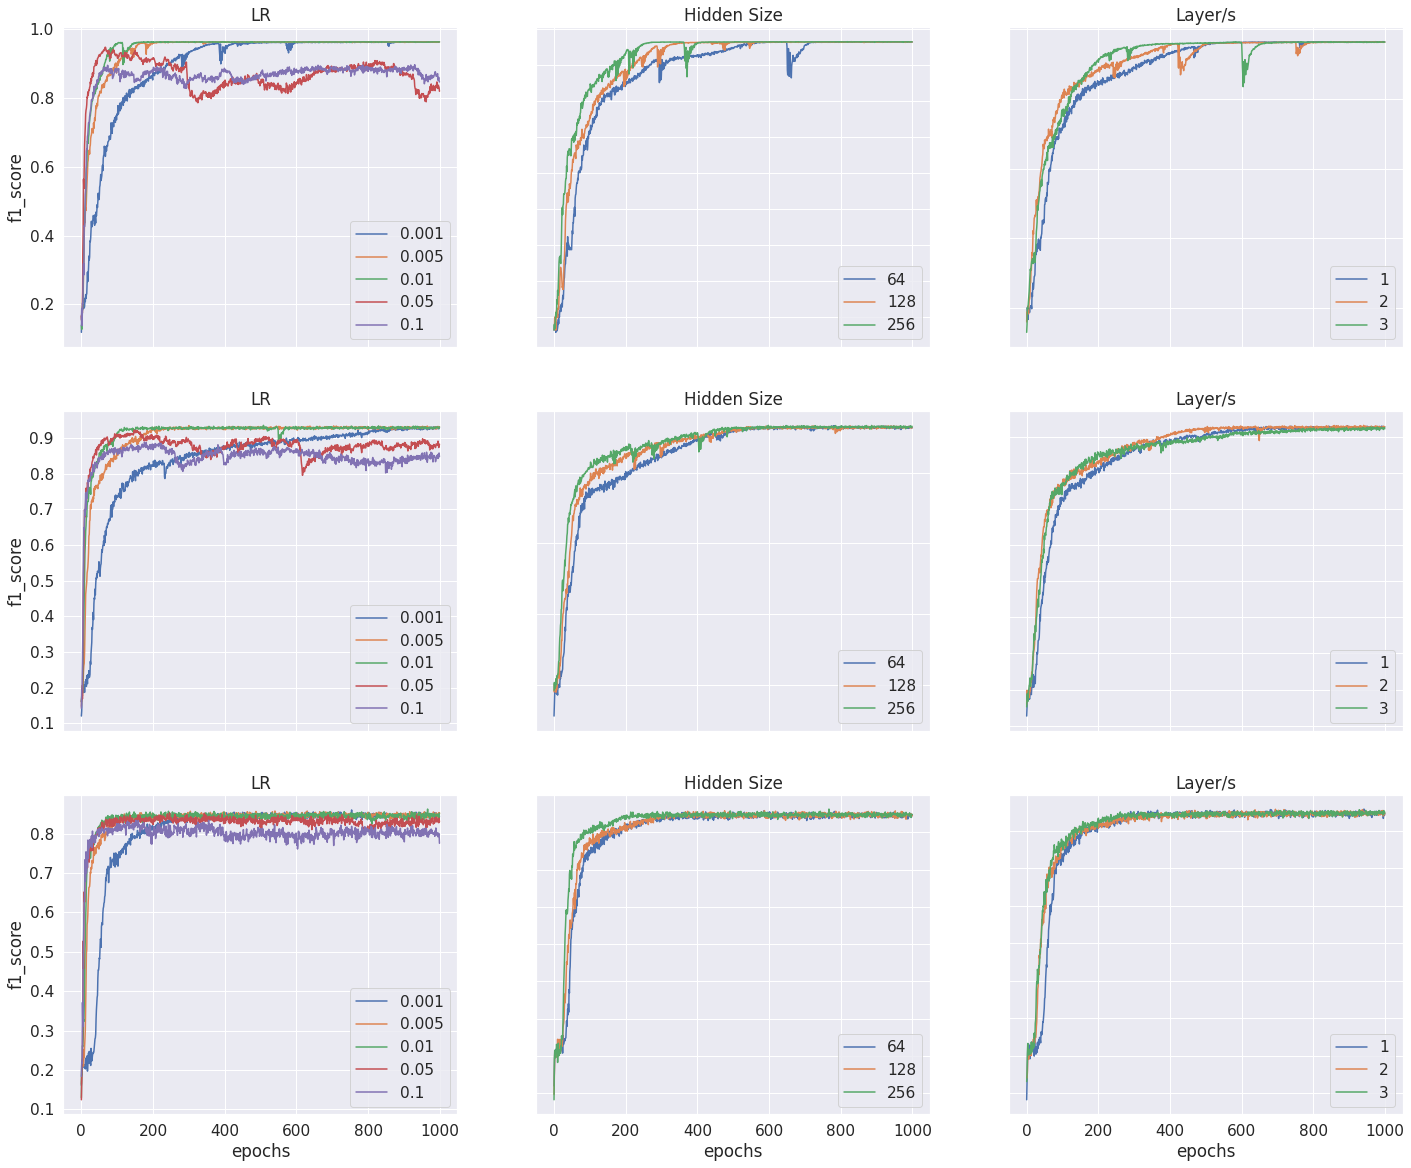

In [ ]:
plot_results('f1_score','f1_score')

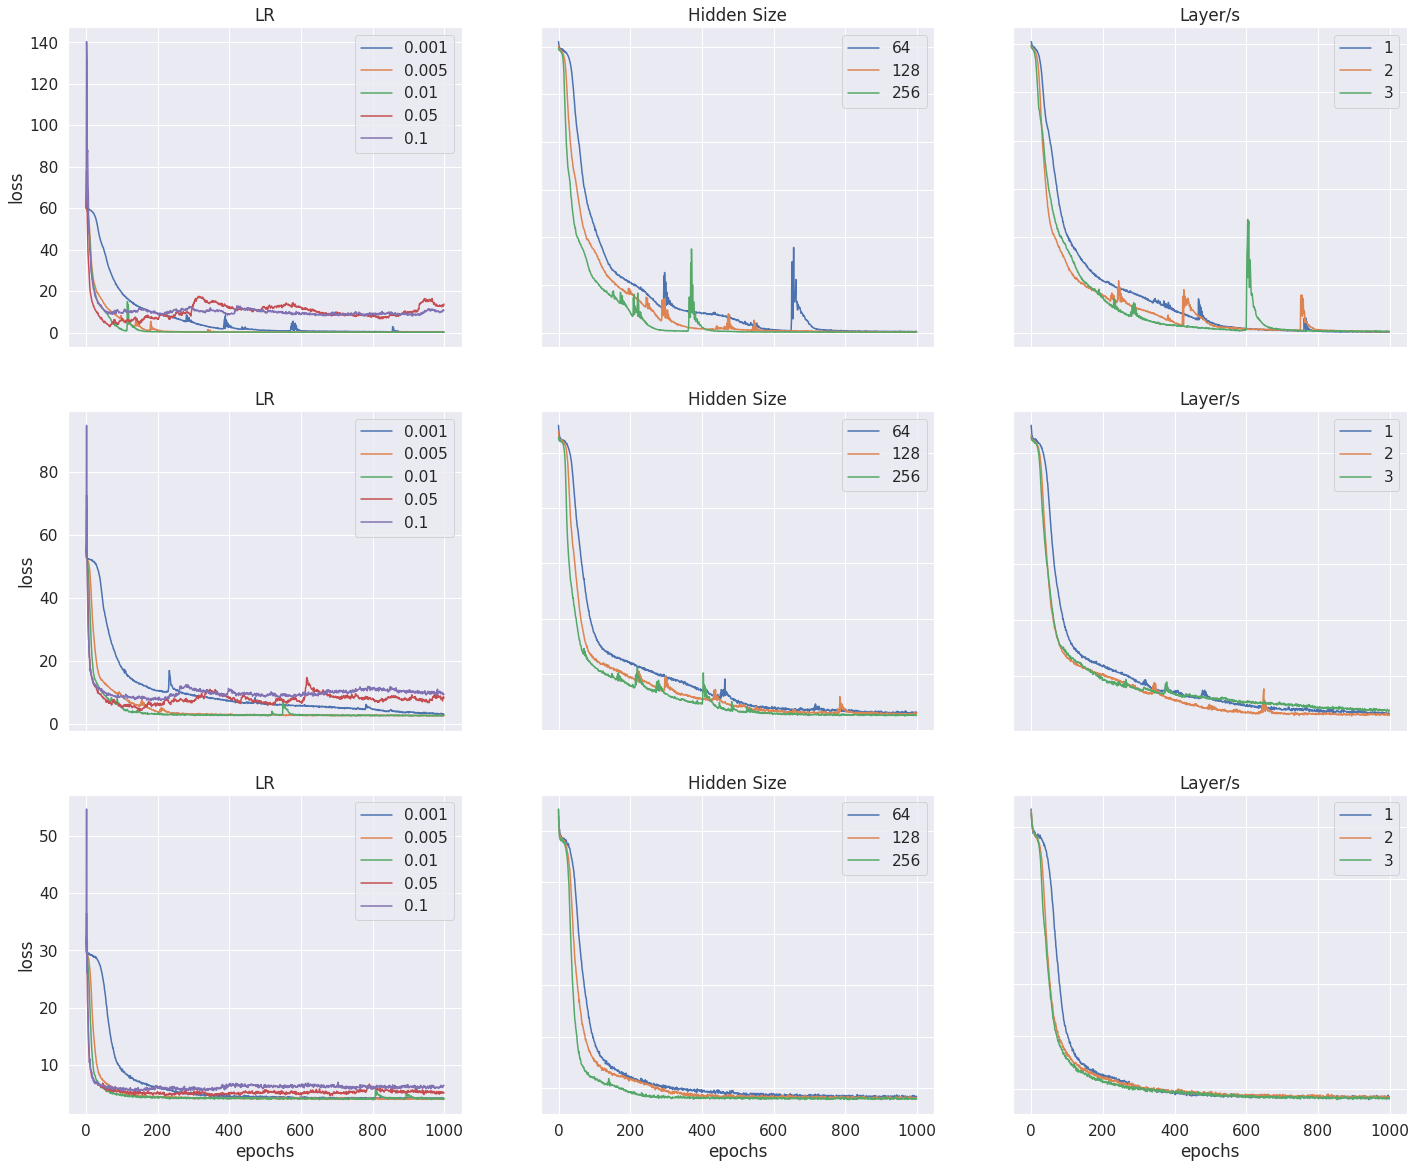

In [ ]:
plot_results('losses','loss')

Comparison to benchmark module langdetect:

In [ ]:
%pip install langdetect

In [ ]:
from langdetect import detect_langs
from langdetect import detect

def convertcode(lang, towiki=True):
  if towiki==True:
    lang = labels['Wiki Code'].where(labels['English'] == lang).dropna().values[0]
  else:
    lang = labels['English'].where(labels['Wiki Code'] == lang).dropna().values[0]
  return lang

knownlangs = ('af, ar, bg, bn, ca, cs, cy, da, de, el, en, es, et, fa, fi, fr, gu, he, hi, hr, hu, id, it, ja, kn, ko, lt, lv, mk, ml, mr, ne, nl, no, pa, pl, pt, ro, ru, sk, sl, so, sq, sv, sw, ta, te, th, tl, tr, uk, ur, vi, zh-cn, zh-tw').split(", ")
#print(knownlangs)
languages = dsl_groups_ABC
languageswiki = [convertcode(i, towiki=True) for i in languages]
languageswiki = list(set(languageswiki).intersection(knownlangs))
usedlangs = [convertcode(i, towiki=False) for i in languageswiki]

print(usedlangs)

In [ ]:
n_instances = [200]
ldcorrect = 0
nlanguages = len(usedlangs)
y_pred = []

for n_instance in n_instances:

  x_test, y_test = get_data_chunk(X_Test, Y_Test, n_instance, usedlangs)
  for x, y in zip(x_test, y_test):
    y = convertcode(y)
    #print(x[:50], "... \nLanguage:", y)
    y_prd = detect(x)
    #print("y_pred =", detect(x))
    if y_prd == y:
      ldcorrect += 1
    else:
      print(y_prd, y)

    y_pred.append(convertcode(y_prd, False))

  ldaccuracy = ldcorrect/(nlanguages*n_instance)
  print("Accuracy of langdetect with",n_instance,"paragraphs per language = ",ldaccuracy)
  # take a paragraph/s (instance/s) at a time, feed to langdetect
  # compare langdetect output (probabilities or best-guess language) with the true label
  # calculate accuracy
  # calculate confusion matrix
  # run our RNN trained with optimised hyperparams on the same paragraphs
  # compare accuracy and confusion matrix

In [ ]:
ldcf_mat = confusion_matrix(y_test, y_pred)
print(set(y_pred))
print(set(y_test))
print(ldcf_mat)
print((ldcf_mat).shape)

In [ ]:
# code for heatmaps:
group_counts = ["{0:0.0f}\n".format(value) for value in ldcf_mat.flatten()]
# we want percentages to show % of predictions in each true cell, which means the the sums should be done by row
group_percentages = ["{0:.2%}".format(value) for value in (ldcf_mat/ldcf_mat.sum(axis=1)).flatten()]
box_labels = [f"{v1}{v2}".strip() for v1, v2 in zip(group_counts, group_percentages)]    
box_labels = np.asarray(box_labels).reshape(ldcf_mat.shape[0], ldcf_mat.shape[1])
plt.subplots(figsize=(10,10))

sns.heatmap(ldcf_mat, cmap='coolwarm', annot=box_labels, fmt="", linewidths=1.5)#, xticklabels=set(y_pred), yticklabels=set(y_pred))
plt.xlabel("Predicted Language Label")
plt.ylabel("True Language Label")
plt.show()